In [2]:
import networkx as nx
import pickle
import matplotlib.pyplot as plt
from sklearn import cluster
import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score

## Import network, extract data, and subset harbours

In [2]:
# import network
G = pickle.load(open('data/network_digital_twin_v0.3.pickle', 'rb'))


# extract position for drawing purposes
pos_dict = {}
for node in G.nodes:
    pos_dict[node] = (G.nodes[node]['X'],G.nodes[node]['Y'])

#extract data
df_links = nx.to_pandas_edgelist(G)
df_nodes = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')

# select berth nodes
berth_nodes = df_nodes.loc[df_nodes.n.str.contains('Berth')].index

# Step 1: review and clean original network

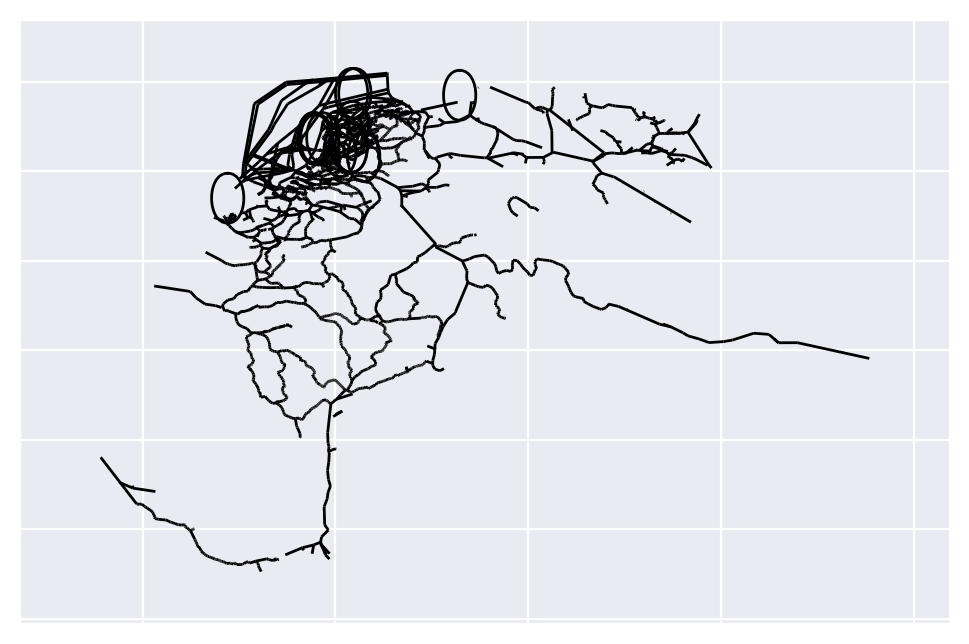

In [3]:
# visualize complete network
fig, ax = plt.subplots(dpi=200)
nx.draw_networkx_edges(G, pos=pos_dict, width=1)

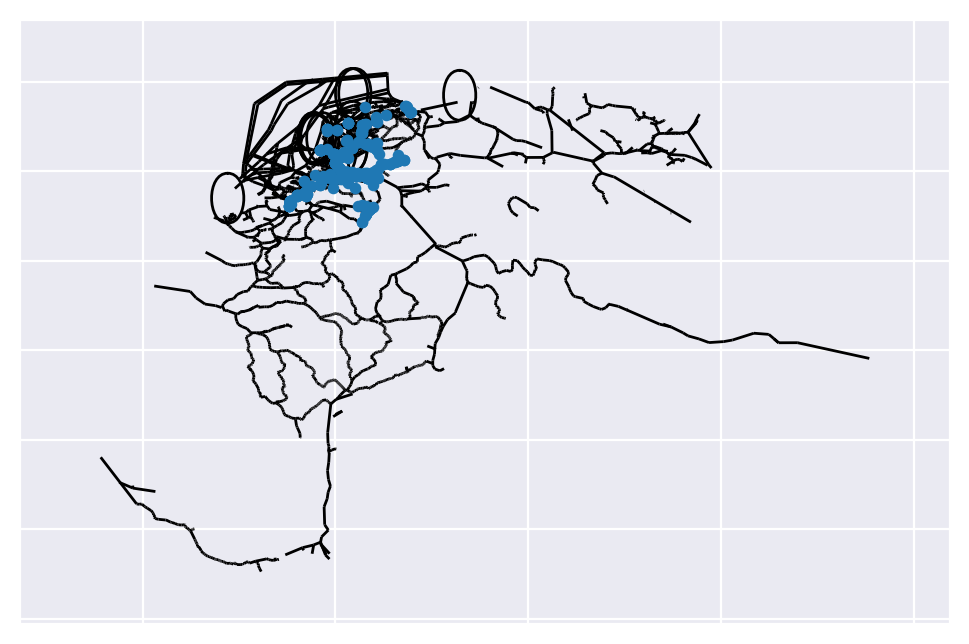

In [4]:
# now only plot the harbour nodes (with Berth in name)
fig, ax = plt.subplots(dpi=200)
nx.draw_networkx_nodes(G, pos_dict, berth_nodes, node_size=10)
nx.draw_networkx_edges(G, pos_dict, width = 1)
#good, harbour nodes appear to be quite strictly located in the netherlands

### Apply boundary box based on harbour nodes

## 1. Subset based on lat and lon harbours

In [5]:
# subset graph with harbours to be able to access X and Y for harbour nodes
df_nodes_harbours = df_nodes.loc[df_nodes.n.str.contains('Berth')]

In [6]:
#create boundary box
min_y = df_nodes_harbours.Y.min()
max_y = df_nodes_harbours.Y.max()
min_x = df_nodes_harbours.X.min()
max_x = df_nodes_harbours.X.max()

In [7]:
df_nodes = df_nodes.loc[(df_nodes.X.between(min_x, max_x)) & (df_nodes.Y.between(min_y, max_y))]

In [8]:
#visualise new subset

G = G.subgraph(df_nodes.index)

In [9]:
G = nx.Graph(G)

## Remove links from i to i

In [10]:
for node1, node2 in G.edges:
    if node1 == node2:
        print("Self loop identified node", node1)
        G.remove_edge(node1,node2)

Self loop identified node S46058_A
Self loop identified node S51275_A
Self loop identified node S16237927_A
Self loop identified node S48415_A
Self loop identified node S16240_A
Self loop identified node S24198_A
Self loop identified node S27425_A
Self loop identified node S28525_A
Self loop identified node S28525_B
Self loop identified node S56863_A
Self loop identified node S56863_B
Self loop identified node S57264_A


## Only keep nodes and edges that are on Dijkstra paths between Berth nodes

In [11]:
# node_list = []
# for origin_berth in berth_nodes:
#     a = list(berth_nodes)
#     a.remove(origin_berth)
#     for dest_berth in a:
#         try:
#             path = nx.dijkstra_path(G,origin_berth,dest_berth,'length_m')
#             node_list =  list(set(path) & set(node_list))
#         except:
#             print(f'no path from {origin_berth} to {dest_berth}')

In [12]:
# H = G.subgraph(berth_nodes)
# H = nx.Graph(H)

node_list = []
for node_1 in berth_nodes:
    a = df_nodes_harbours.loc[(df_nodes_harbours.X.between(df_nodes_harbours['X']-1, df_nodes_harbours['X']+1)) & (df_nodes_harbours.Y.between(df_nodes_harbours['Y']-1, df_nodes_harbours['Y']+1))&(df_nodes_harbours.index != node_1)]
    for node_2 in a.index:
            # determine route from a to b
        try:
            # get path
            path = nx.dijkstra_path(G, node_1, node_2, 'length_m')

            # add nodes to node list
            node_list.append(path)

            #remove duplicates
            node_list = list(set(node_list))

        except:
            print('no path between', node_1, node_2)

no path between Berth270 Berth0
no path between Berth270 Berth1
no path between Berth270 Berth2
no path between Berth270 Berth3
no path between Berth270 Berth4
no path between Berth270 Berth5
no path between Berth270 Berth6
no path between Berth270 Berth7
no path between Berth270 Berth8
no path between Berth270 Berth9
no path between Berth270 Berth10
no path between Berth270 Berth11
no path between Berth270 Berth12
no path between Berth270 Berth13
no path between Berth270 Berth14
no path between Berth270 Berth15
no path between Berth270 Berth16
no path between Berth270 Berth17
no path between Berth270 Berth18
no path between Berth270 Berth19
no path between Berth270 Berth20
no path between Berth270 Berth21
no path between Berth270 Berth22
no path between Berth270 Berth23
no path between Berth270 Berth24
no path between Berth270 Berth25
no path between Berth270 Berth26
no path between Berth270 Berth27
no path between Berth270 Berth28
no path between Berth270 Berth29
no path between Bert

In [17]:
df_nodes

n         X          Y  \
8867414    8867414  4.952974  52.376549   
8865307    8865307  4.954211  52.374431   
8864726    8864726  5.756117  52.573627   
8861055    8861055  5.757859  52.578609   
8861526    8861526  4.860551  52.396724   
...            ...       ...        ...   
Berth302  Berth302  5.222425  51.815990   
Berth303  Berth303  5.221081  51.815669   
8865499    8865499  5.219022  51.815177   
Berth305  Berth305  4.966948  51.827939   
22638307  22638307  4.967101  51.827933   

                                                   geometry  \
8867414   {'type': 'Point', 'coordinates': (4.9529743328...   
8865307   {'type': 'Point', 'coordinates': (4.9542113637...   
8864726   {'type': 'Point', 'coordinates': (5.7561165780...   
8861055   {'type': 'Point', 'coordinates': (5.7578594317...   
8861526   {'type': 'Point', 'coordinates': (4.8605511761...   
...                                                     ...   
Berth302  {'type': 'Point', 'coordinates': (5.2224246051...   
Berth303  {'type': 'Point', 'coordinates': (5.2210806772...   
8865499   {'type': 'Point', 'coordinates': (5.2190220131...   
Berth305  {'type': 'Point', 'coordinates': (4.9669477560...   
22638307  {'type': 'Point', 'coordinates': (4.9671009281...   

                                                     Wkt  
8867414   POINT (4.9529743328171900 52.3765489377136007)  
8865307   POINT (4.9542113637339202 52.3744310413327980)  
8864726   POINT (5.7561165780084798 52.5736268471534984)  
8861055   POINT (5.7578594317824701 52.5786094645163971)  
8861526   POINT (4.8605511761302900 52.3967238141143028)  
...                                                  ...  
Berth302  POINT (5.2224246051149352 51.8159898381213324)  
Berth303  POINT (5.2210806772796499 51.8156686832568596)  
8865499   POINT (5.2190220131971898 51.8151767297702008)  
Berth305  POINT (4.9669477560782163 51.8279388662828069)  
22638307  POINT (4.9671009281155802 51.8279326726516985)  

[10034 rows x 5 columns]

In [26]:
expanded_node_list = [x for xs in node_list for x in xs]

In [28]:
node_list = list(set(expanded_node_list))

In [30]:
G = G.subgraph(node_list)

In [31]:
G = nx.Graph(G)

## Visualize resulting network

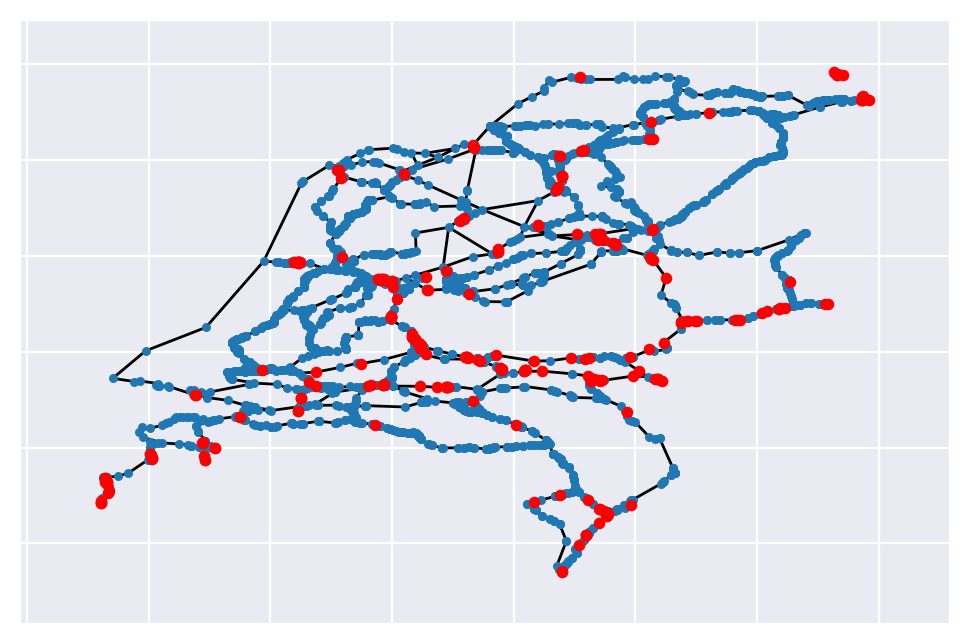

In [8]:
plt.subplots(dpi=200)
nx.draw_networkx_edges(G, pos_dict)
nx.draw_networkx_nodes(G, pos_dict, node_size=5)
nx.draw_networkx_nodes(G, pos_dict, berth_nodes, node_size=10, node_color='red')


## Assessing nodes which are not connected to the main graph
However, there are clearly some islands. Q: how many harbour nodes are not connected to the network now?
Should they be connected manually? Otherwise, they should be deleted.

In [13]:
island_nodes = []
for node in berth_nodes:
    try:
        nx.dijkstra_path(G, "Berth10", node, weight='length_m')
    except:
        print("Node", node, "seems to be on an island")
        island_nodes.append(node)

Node Berth39 seems to be on an island
Node Berth38 seems to be on an island
Node Berth280 seems to be on an island
Node Berth279 seems to be on an island
Node Berth196 seems to be on an island


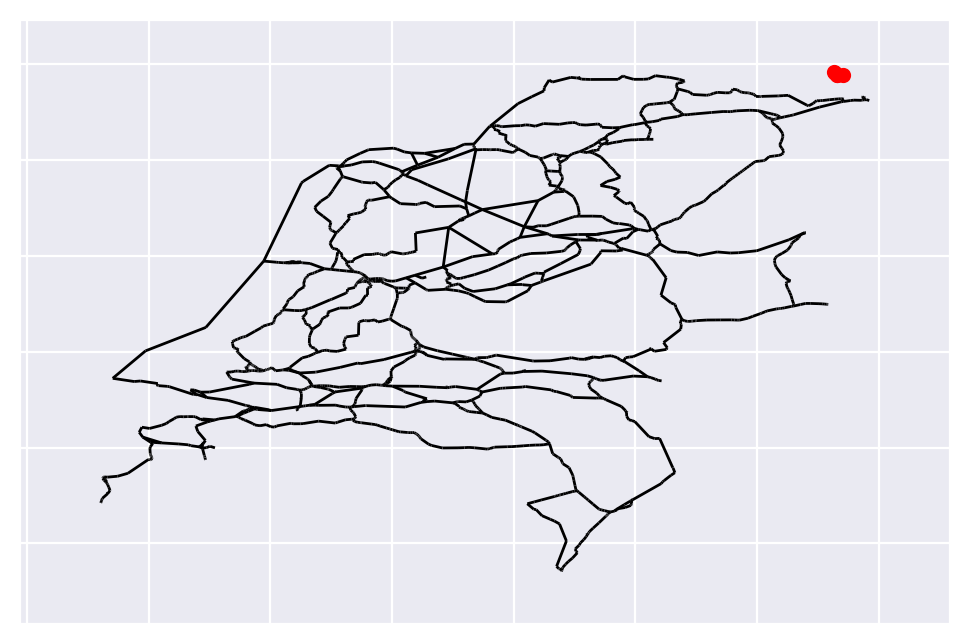

In [14]:
fig, ax = plt.subplots(dpi=200)
nx.draw_networkx_edges(G, pos_dict)
nx.draw_networkx_nodes(G, pos_dict, island_nodes, node_size=20, node_color='red')

In [15]:
G.remove_nodes_from(island_nodes)

In [22]:
berth_nodes= list(berth_nodes)

In [23]:
# also remove Berth nodes berth list
for i in island_nodes:
    berth_nodes.remove(i)

## Final result

In [25]:
# save cleaned graph and berths
pickle.dump( berth_nodes, open( "data/berth_nodes.p", "wb" ) )
pickle.dump( G, open( "data/cleaned_network.p", "wb" ) )

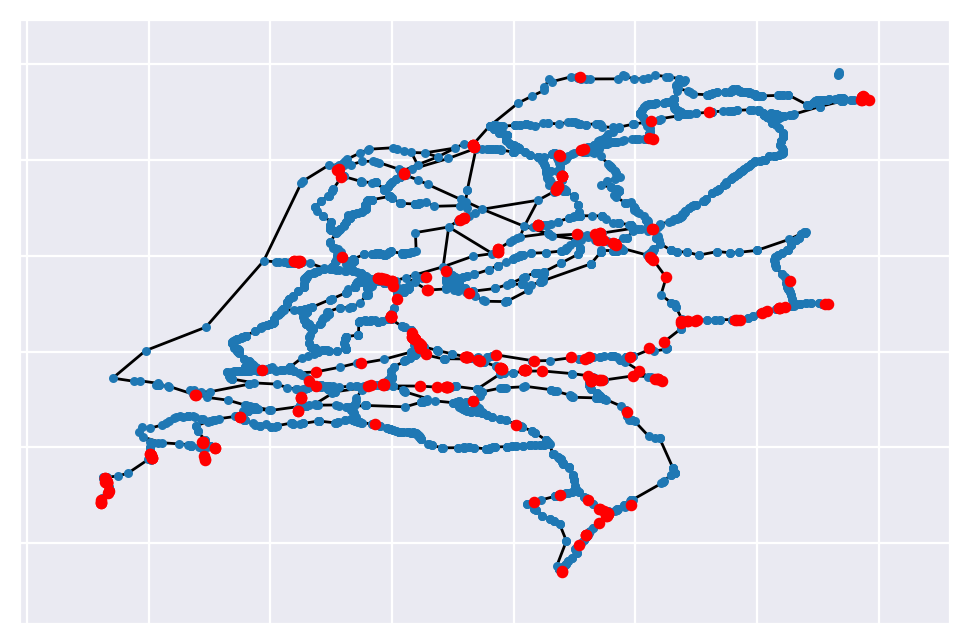

In [26]:
plt.subplots(dpi=200)
nx.draw_networkx_edges(G, pos_dict)
nx.draw_networkx_nodes(G, pos_dict, node_size=5)
nx.draw_networkx_nodes(G, pos_dict, berth_nodes, node_size=10, node_color='red')

## Extra: visualize a route on the network

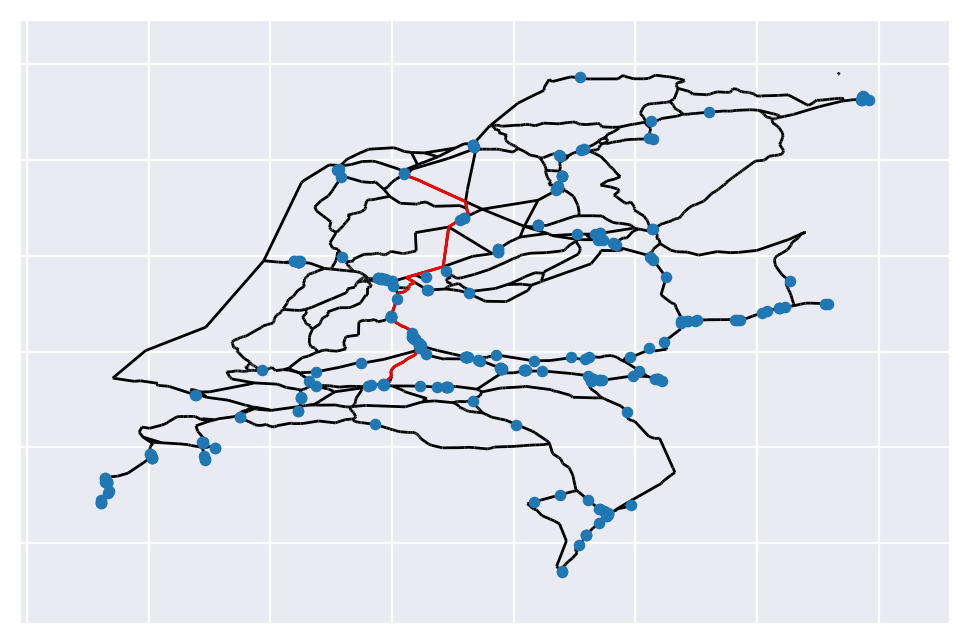

In [27]:
fig, ax = plt.subplots(dpi=200)
route1=nx.dijkstra_path(G,"Berth195", 'Berth10', weight='length_m')

edges_route_1 = []
for i in range(len(route1)-1):
    edges_route_1.append((route1[i],route1[i+1]))

nx.draw_networkx_edges(G, pos_dict)
nx.draw_networkx_nodes(G, pos_dict, berth_nodes, node_size=10)
nx.draw_networkx_edges(G,pos_dict,edges_route_1, edge_color='red')